In [22]:
%reload_ext autoreload
%reload_ext watermark
%autoreload 2
%matplotlib inline
%watermark -v -p torch,fastai

CPython 3.6.7
IPython 7.1.1

torch 1.0.0.dev20181116
fastai 1.0.24


In [23]:
import json
gpus = !gpustat --json
print('\n'.join(
    [f"{i['name']} {i['memory.total']} MB" for i in json.loads(gpus.s)['gpus']]
))

GeForce GTX 1080 8119 MB


In [2]:
from fastai import accuracy, error_rate, plt
from fastai.vision.models import resnet34, resnet50
from fastai.vision import (
    create_cnn,
    ImageDataBunch,
    ClassificationInterpretation,
    imagenet_stats,
    open_image)
from fastai.vision.transform import get_transforms

PATH = "/data/dogscats/"

# https://docs.fast.ai/vision.transform.html#get_transforms
tfms = get_transforms(
    do_flip=True,  # if True, a random flip is applied with probability 0.5
    flip_vert=False,  # If True, the image can be flipped vertically or rotated of 90 degrees, otherwise only an horizontal flip is applied
    max_rotate=20,  # default=10.0 a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
    max_zoom=1.1,  # if not 1. or less, a random zoom betweem 1. and max_zoom is applied with probability p_affine
    max_lighting=None,  # default=0.2 if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
    max_warp=None,  # default=0.2  if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
    p_affine=0.75,  # the probability that each affine transform and symmetric warp is applied
    p_lighting=0.75,  # the probability that each lighting transform is applied
    xtra_tfms=None,  # a list of additional transforms you would like to be applied https://docs.fast.ai/vision.transform.html#List-of-transforms
)

In [3]:
# https://docs.fast.ai/vision.transform.html#Data-augmentation
def get_ex():
    return open_image("/data/dogscats/sample/valid/cats/cat.4785.jpg")


def plots_f(rows, cols, width, height, **kwargs):
    [
        get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax)
        for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=(width, height))[1].flatten()
        )
    ]

In [4]:
get_ex().shape

torch.Size([3, 374, 500])

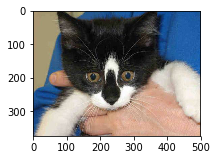

In [5]:
get_ex().show(hide_axis=False)

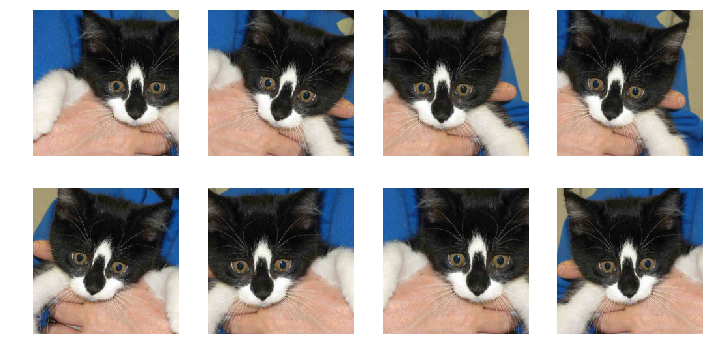

In [6]:
# check how our transformation looks like
plots_f(2, 4, 12, 6, size=224)

#### Useful links
- https://docs.fast.ai/vision.data.html#ImageDataBunch
- https://forums.fast.ai/t/batch-size-effect-on-validation-accuracy/413/5


In [7]:
data = ImageDataBunch.from_folder(path=PATH, ds_tfms=tfms, bs=198, size=224, num_workers=8)

In [8]:
data.classes

['cats', 'dogs']

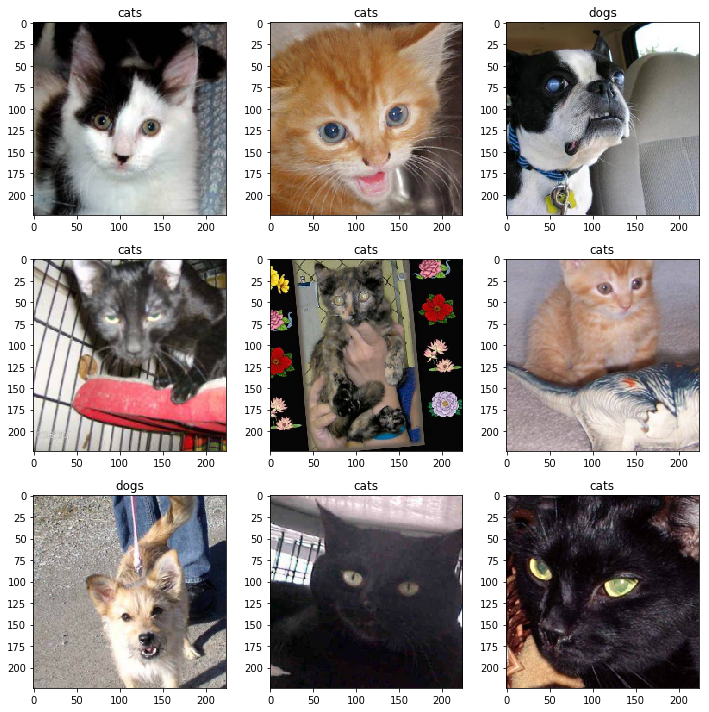

In [9]:
data.show_batch(3, figsize=(10,10), hide_axis=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


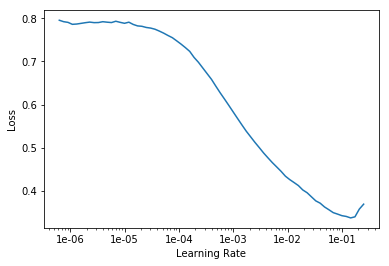

In [10]:
data.normalize()
learn = create_cnn(data, resnet34, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [11]:
help(learn.fit_one_cycle)

Help on method fit_one_cycle in module fastai.train:

fit_one_cycle(cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, **kwargs) -> None method of fastai.basic_train.Learner instance
    Fit a model following the 1cycle policy.



#### Useful links
- https://docs.fast.ai/basic_train.html#fit_one_cycle
- https://docs.fast.ai/callbacks.one_cycle.html#OneCycleScheduler
- https://forums.fast.ai/t/why-does-accuracy-differs-though-the-learning-rate-is-kept-constant/19679
- https://forums.fast.ai/t/notes-on-the-impact-of-learning-rates-and-epochs-on-accuracy/12587

In [12]:
learn.fit_one_cycle(
    2,
    max_lr=1.25e-3  # default=slice(None, 0.003, None)
)

Total time: 02:32
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.077669    0.024602    0.011000    0.989000  (01:16)
2      0.039135    0.023573    0.006000    0.994000  (01:15)



In [13]:
learn.save('lession1-resnet34-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


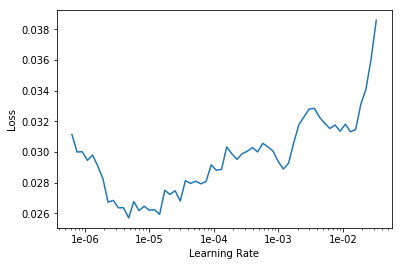

In [14]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.load('lession1-resnet34-1')
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))

Total time: 04:42
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.031436    0.024114    0.008000    0.992000  (01:33)
2      0.029712    0.021908    0.006500    0.993500  (01:33)
3      0.028301    0.021141    0.005500    0.994500  (01:36)



In [32]:
learn.save('lession1-resnet34-2')

#### Results interpretation
Useful links
- https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
- https://medium.com/@diazagasatya/transfer-learning-classification-of-4-different-types-of-arctic-dog-using-fast-ai-library-665cb424af5e

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


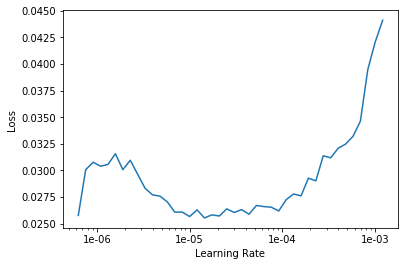

In [33]:
learn.lr_find()
learn.recorder.plot()

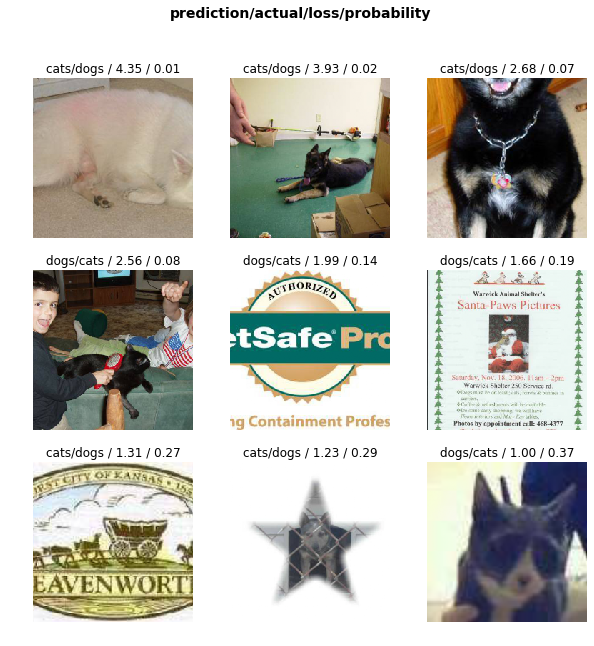

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(10,10))

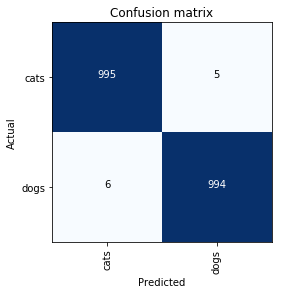

In [36]:
interp.plot_confusion_matrix()

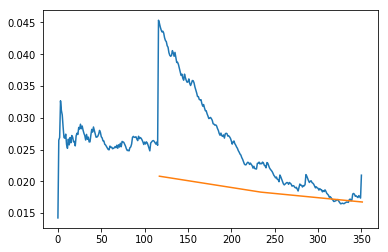

In [37]:
learn.recorder.plot_losses()

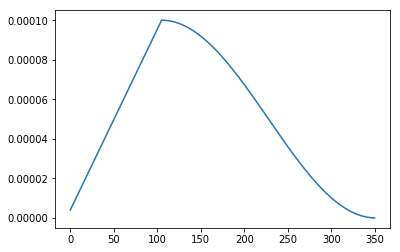

In [38]:
learn.recorder.plot_lr()